In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random

# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'  # force cpu
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

# Load words
words = []
# with open("./data/western_names.txt") as file:
#     words = file.read().splitlines()

with open("./data/indian_names.csv", encoding="utf-8") as file:
    df = pd.read_csv(file, header=None)
    words = df.iloc[:, 0].dropna().tolist()
    words = [w.lower() for w in words if w.isalpha()]
    words = words[1:]
words[0:10]
min(len(w) for w in words), max(len(w) for w in words)
len("".join(w for w in words)) + len(words)  # total chars from all words +len(words) for the dots

Using device: cpu
GPU: NVIDIA GeForce MX450
CUDA version: 12.6


45594

In [77]:
# Initialize character embeddings
unique_tokens = sorted(list(set("".join(words))))

token_to_idx = {ch: i + 1 for i, ch in enumerate(unique_tokens)}
token_to_idx["."] = 0
idx_to_token = {i: ch for ch, i in token_to_idx.items()}
vocab_size = len(token_to_idx)
eps = 1e-5

# hyperparameters on cpu
context_size = 4
embed_size = 8
batch_size = 32
network_size = 128

# hyperparameters on gpu
# context_size = 8
# embed_size = 64
# batch_size = 2048
# network_size = 1024


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * context_size
        for ch in w + ".":
            idx = token_to_idx[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [78]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True, generator=None, device=None):
        self.weight = torch.randn((fan_in, fan_out), generator=generator, device=device) / fan_in ** 0.5
        self.bias = torch.zeros(1, fan_out, device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight, self.bias] if self.bias is not None else [self.weight]

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1, device=None):
        self.eps = eps
        self.momentum = momentum
        self.dim = dim
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)
        self.training = True

    def __call__(self, x):
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True, unbiased=False)
        else:
           x_mean = self.running_mean
           x_var = self.running_var
        
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta

        if(self.training):
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [79]:
# Initialize parameters
g = torch.Generator(device=device).manual_seed(2147483647)

E = torch.randn((vocab_size, embed_size), generator=g, device=device)

Layers = [
    Linear(context_size * embed_size, network_size, bias=False, generator=g, device=device), BatchNorm1d(network_size, device=device), Tanh(),
    Linear(network_size, network_size, bias=False, generator=g, device=device), BatchNorm1d(network_size, device=device), Tanh(),
    Linear(network_size, network_size, bias=False, generator=g, device=device), BatchNorm1d(network_size, device=device), Tanh(),
    Linear(network_size, network_size, bias=False, generator=g, device=device), BatchNorm1d(network_size, device=device), Tanh(),
    Linear(network_size, network_size, bias=False, generator=g, device=device), BatchNorm1d(network_size, device=device), Tanh(),
    Linear(network_size, vocab_size, bias=False, generator=g, device=device), BatchNorm1d(vocab_size, device=device),
]

with torch.no_grad():
    Layers[-1].gamma *= 0.1
    for layer in Layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)

parameters = [E] + [p for layer in Layers for p in layer.parameters()]
print("parameters: ", sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

parameters:  74638


In [80]:
# training
X = X_train
Y = Y_train
lossi = []
ud =[]

for i in range(10_000):
    # mini-batch
    ix = torch.randint(0, X.size(0), (batch_size,), device=device).long()
    X_batch, Y_batch = X[ix], Y[ix]

    # forward pass
    I = E[X_batch].view(-1, context_size * embed_size)

    for layer in Layers:
        I = layer(I)
        # print(layer.__class__.__name__, I.shape)

    loss = F.cross_entropy(I, Y_batch)

    # backward pass
    # for layer in Layers:
    #     layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    learning_rate = 0.05 if i < 50_000 else 0.01
    for p in parameters:
        p.data += learning_rate * -p.grad

    # track stats
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((learning_rate * p.grad).std() / p.data.std()).log10().item() for p in parameters])
    if (i + 1) % 1_000 == 0:
        print(f"{i+1}: {loss.item():.4f}")

    # break
    if i >= 1000:
        break  # AFTER_DEBUG: would take out obviously to run full optimization

print(loss.item())

1000: 1.9920
2.1070916652679443


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 6.03%
layer 5 (      Tanh): mean -0.00, std 0.65, saturated: 5.08%
layer 8 (      Tanh): mean +0.00, std 0.67, saturated: 5.03%
layer 11 (      Tanh): mean -0.00, std 0.67, saturated: 4.32%
layer 14 (      Tanh): mean -0.00, std 0.69, saturated: 3.71%


Text(0.5, 1.0, 'activation distribution')

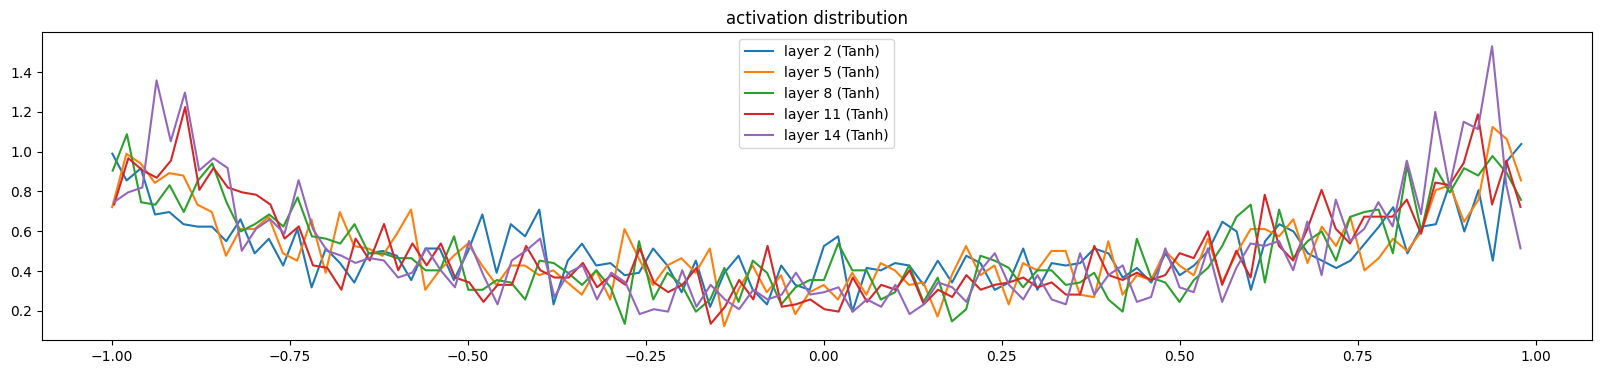

In [62]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(Layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean -0.000000, std 4.781741e-03
layer 5 (      Tanh): mean +0.000000, std 4.317045e-03
layer 8 (      Tanh): mean -0.000000, std 4.049204e-03
layer 11 (      Tanh): mean -0.000000, std 3.946966e-03
layer 14 (      Tanh): mean -0.000000, std 3.926754e-03


Text(0.5, 1.0, 'gradient distribution')

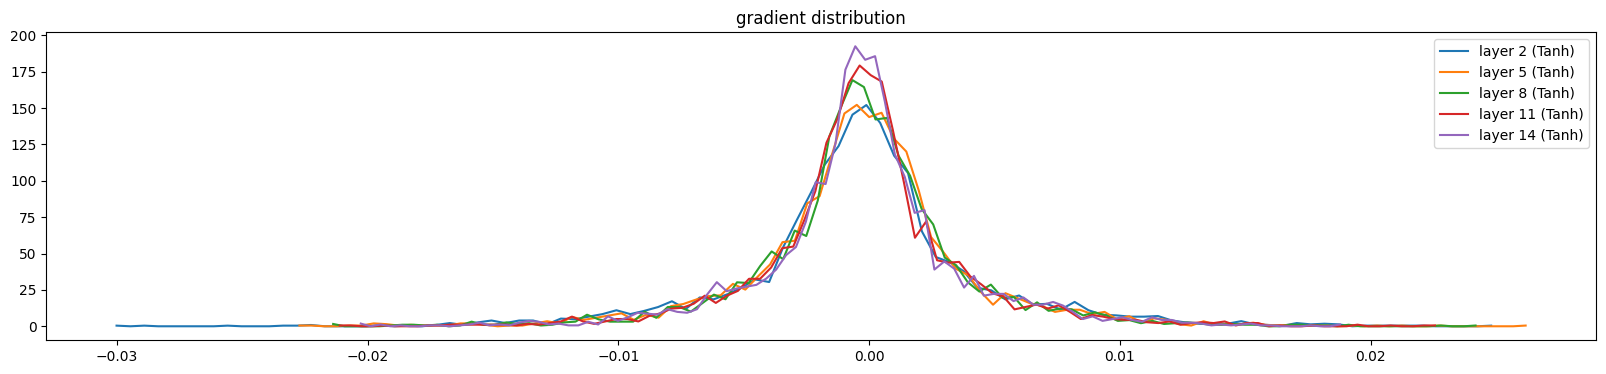

In [63]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(Layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+f, std %e"
            % (i, layer.__class__.__name__, t.mean(), t.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distribution")

weight   (27, 16) | mean +0.000000 | std 1.156963e-02 | grad:data ratio 1.176501e-02
weight  (64, 128) | mean +0.000338 | std 1.131578e-02 | grad:data ratio 5.139866e-02
weight (128, 128) | mean -0.000092 | std 8.626348e-03 | grad:data ratio 5.514967e-02
weight (128, 128) | mean -0.000077 | std 8.072106e-03 | grad:data ratio 5.193372e-02
weight (128, 128) | mean -0.000017 | std 7.771758e-03 | grad:data ratio 5.002605e-02
weight (128, 128) | mean -0.000022 | std 7.422287e-03 | grad:data ratio 4.793818e-02
weight  (128, 27) | mean -0.000160 | std 1.572289e-02 | grad:data ratio 8.984058e-02


Text(0.5, 1.0, 'weights gradient distribution')

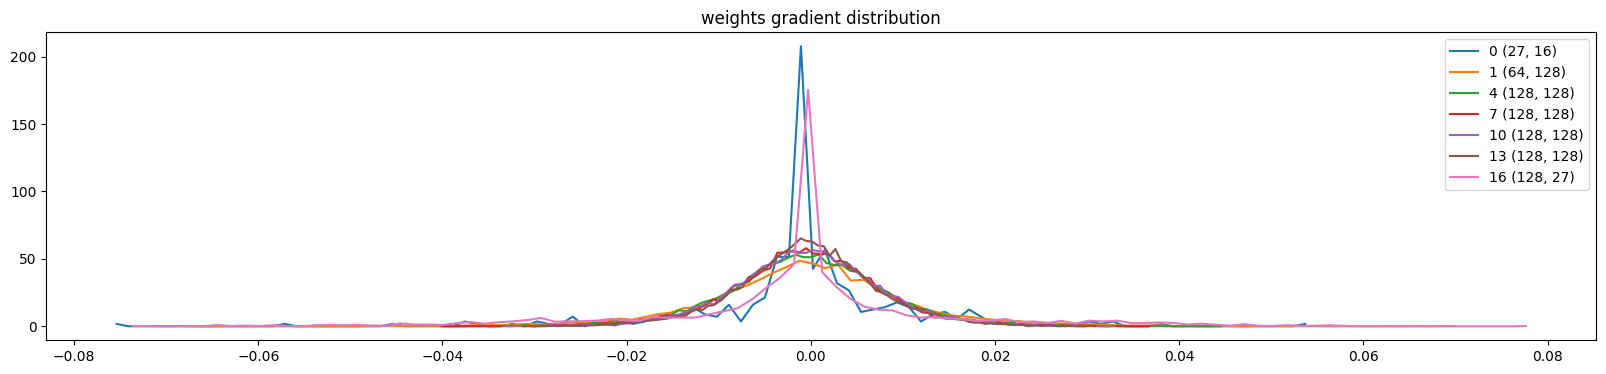

In [64]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            "weight %10s | mean %+f | std %e | grad:data ratio %e"
            % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution")

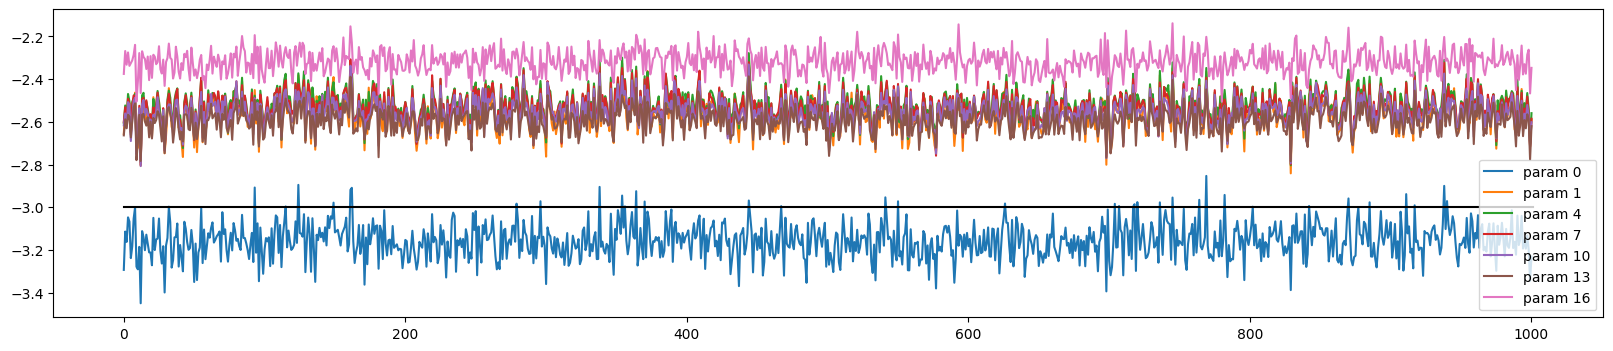

In [65]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [66]:
@torch.no_grad()
def loss_by_split(split):
    X, Y = {
        "train": (X_train, Y_train),
        "val": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]
    I = E[X].view(-1, context_size * embed_size)

    for layer in Layers:
        I = layer(I)

    loss = F.cross_entropy(I, Y)
    print(split, loss.item())


loss_by_split("val")
loss_by_split("test")

val 1.4756720066070557
test 1.4773564338684082


In [75]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * context_size

    while True:
        # forward pass the neural net
        I = E[torch.tensor([context])].view(-1, context_size * embed_size)

        for layer in Layers:
            I = layer(I)
        logits = I

        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(idx_to_token[i] for i in out))  # decode and print the generated word

aahbdramavmbaaggaxaeafamshilaaganairdmknbvrarcmloae.
raaimmauaraaaeguktarn.
mbniariamrtlthdmaasahjiaarruairvaaousoreperxbswirigoeakhuilinsaebrhioaashmae.
acnahfhgnahesbiarkhdkaarnaya.
aizatgraaiooanar.
aaabaesaavasriarsanrrg.
.
hrrecnpfa.
basrau.
.
ssvubhriirnavhalr.
an.
aaumsaoseaparmauasauirmausegaarfaruqysm.
.
dtarr.
uniilurmasxr.
boauabphandimmaoa.
rbuowpkraa.
hlae.
mthoitargnaaiamiadraubdaaiazysrzairhama.
